In [2]:
import torch
import torch.nn as nn
from torch.func import jacrev, jacfwd, vmap

import numpy as np
import matplotlib.pyplot as plt # need 3.10 plus for "berlin" cmap
import matplotlib.colors as mcolors

from simulate import simulate_convergence, simulate_merge, simulate_branching, simulate_deflection, simulate_ridge
from visualise import visualise_v_quiver, visualise_v_stream

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Call or forward?

In [ ]:
# Generate Berlin colormap although it is only available in Matplotlib 3.10
# Load tensor for berlin (dark diverging cmap) from folder
cmap_berlin_tensor = torch.load("configs/vis/cmap_berlin_tensor.pt")

# convert to list
_berlin_data = cmap_berlin_tensor.tolist()

from matplotlib.colors import ListedColormap

cmaps = {
    name: ListedColormap(data, name = name) for name, data in [
        ('berlin', _berlin_data),
    ]}

cmaps['berlin']

In [3]:
class MLP_compute_v_pointwise(nn.Module):
    # for a single point
    def __init__(self, input_dim = 2, hidden_dim = 32):
        super().__init__()

        self.input_dim = input_dim
        
        # Output dim follows input dims
        # for 2D input the NN output dim is 1
        self.output_dim = int((input_dim * (input_dim - 1)) / 2)

        # Replace with something more sophisticated
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, self.output_dim)
        )

    def forward(self, x):
        # put deterministic transformations here with torch functional

        def A(x):

            # RUN THROUGH NET
            U_fill = self.net(x)
        
            # This version works with vmap, diagonal shifts diagional one up
            U_zero_one = torch.triu(torch.ones(self.input_dim, self.input_dim), diagonal = 1)

            # U_zero_one is (2, 2), U_fill is (1), so we can just scale U_zero_one by U_fill
            U = U_zero_one * U_fill

            # U is (2, 2), so we need to swap the last two dims and then subtract
            A = U - U.T

            return A

        return torch.diagonal(jacfwd(A)(x), dim1 = 1, dim2 = 2).sum(-1)

In [4]:
model = MLP_compute_v_pointwise()

# parse one point
print(model(torch.tensor([1.0, 0.5]))) 

# parse multiple points
print(vmap(model)(torch.tensor([[1.0, 0.5], [0.5, 1.0]])))

tensor([ 0.0154, -0.0149], grad_fn=<SumBackward1>)
tensor([[ 0.0154, -0.0149],
        [-0.0183, -0.0538]], grad_fn=<SumBackward1>)


In [5]:
# overwrite with 20 * 20 grid
N = 20 * 20 # N should be a perfect square
N_side = int(N ** 0.5)

dims = 2

# inputs = torch.randn(N, dims)  # Random (N, 2) inputs
xy_side = torch.linspace(0, 3, N_side)
# torch meshgrid, not default but we want to index by x, y
X_mesh, Y_mesh = torch.meshgrid(xy_side, xy_side, indexing = "xy")

# Construct flat pairs of points
# now the span [0, 3]
inputs_03 = torch.cat([X_mesh.reshape(-1, 1), Y_mesh.reshape(-1, 1)], dim = 1)
print(inputs_03.shape)

torch.Size([400, 2])


In [6]:
# float32 is default for
# x_train = torch.load("data/sim_data/x_train_lines_discretised.pt").float().requires_grad_()
x_train = inputs_03
y_train = simulate_convergence(x_train).float()

print(f"The shape of the training data is {y_train.shape}.")
print(f"The dtype of the input data is {x_train.dtype}.")

# Convert to DataLoader for batching
dataset = TensorDataset(x_train, y_train)
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

# Initialise fresh model
model_v = MLP_compute_v_pointwise()
model_v.train()

# Define loss function (e.g., MSE for regression)
criterion = nn.MSELoss()

# Define optimizer (e.g., Adam)
optimizer = optim.AdamW(model_v.parameters(), lr = 0.0001, weight_decay = 1e-4)
num_epochs = 200

# Initialise tensor to store losses
epoch_losses = torch.zeros(num_epochs)

print()
print("Start Training")
for epoch in range(num_epochs):

    epoch_loss = 0.0  # Accumulate batch losses

    for batch in dataloader:
        x_batch, y_batch = batch
        x_batch.requires_grad_()

        y_pred = vmap(model_v)(x_batch)

        # Compute loss
        loss = criterion(y_pred, y_batch)
        epoch_loss += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # Store the average loss for the epoch
    epoch_losses[epoch] = epoch_loss / len(dataloader)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss (MSE): {loss.item():.4f}")

The shape of the training data is torch.Size([400, 2]).
The dtype of the input data is torch.float32.

Start Training
Epoch 1/200, Training Loss (MSE): 2.9767
Epoch 2/200, Training Loss (MSE): 3.4310
Epoch 3/200, Training Loss (MSE): 2.2356
Epoch 4/200, Training Loss (MSE): 2.5320
Epoch 5/200, Training Loss (MSE): 3.2508
Epoch 6/200, Training Loss (MSE): 2.2882
Epoch 7/200, Training Loss (MSE): 2.0561
Epoch 8/200, Training Loss (MSE): 3.4120
Epoch 9/200, Training Loss (MSE): 3.9999
Epoch 10/200, Training Loss (MSE): 2.7744
Epoch 11/200, Training Loss (MSE): 2.7286
Epoch 12/200, Training Loss (MSE): 3.1611
Epoch 13/200, Training Loss (MSE): 3.3464
Epoch 14/200, Training Loss (MSE): 2.0213
Epoch 15/200, Training Loss (MSE): 3.1680
Epoch 16/200, Training Loss (MSE): 2.4779
Epoch 17/200, Training Loss (MSE): 1.9926
Epoch 18/200, Training Loss (MSE): 2.0134
Epoch 19/200, Training Loss (MSE): 2.4756
Epoch 20/200, Training Loss (MSE): 1.9194
Epoch 21/200, Training Loss (MSE): 1.8294
Epoch 22/

In [ ]:
plt.figure(figsize = (6, 4))
plt.plot(epoch_losses.numpy(), label = "Training Loss", color = "b")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Functional divergence
torch.diagonal(vmap(jacrev(model_v))(x_train), dim1 = 1, dim2 = 2).sum(0)

tensor([0., 0.], grad_fn=<SumBackward1>)

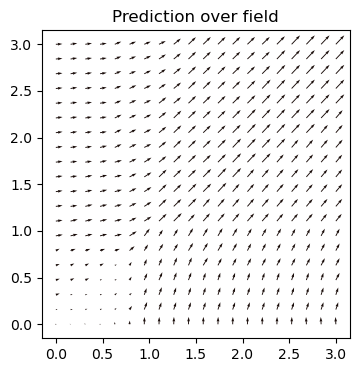

In [ ]:
model_v.eval()

y_pred = vmap(model_v)(x_train)
y_pred.shape

visualise_v_quiver(y_pred.detach(), x_train.detach(), 
                   title_string = "Prediction over field", color_abs_max = 0.2)

In [ ]:
# [out_dim, in_dim1, indim_2]
# vmap(jacfwd(model))(torch.tensor([[1.0, 0.5],[1.2, 0.7], [1.4, 0.8]])).shape

# torch.trace(jacfwd(model)(torch.tensor([1.0, 0.5])))
torch.diagonal(jacfwd(model)(torch.tensor([1.0, 0.5])), dim1 = 1, dim2 = 2).sum(-1)

In [ ]:
jacfwd(model)(torch.tensor([1.0, 0.5]))

In [ ]:
class dfNN(object, network):
    self.network = network

    def __call__(self, x, params):

        # define A() first which is called in the return statement
        def A(x):
            u_v = self.network(x, params)  # Compute the network output
            N = len(x)
            
            A = torch.zeros((N, N), device = x.device)  # Initialize a zero matrix
            idx = torch.triu_indices(N, N, offset = 1)  # Get upper triangular indices
            A[idx[0], idx[1]] = u_v  # Assign values to upper triangular part
            
            return A - A.T  # Make the matrix antisymmetric
        
        return torch.func.jacrev(A)(x)